In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from urllib.parse import urlencode
import json

# Задание 1

Загрузим данные наиболее удобным образом через API. Т.к. файлов несколько, создадим функцию get_data

In [221]:
def get_data(public_key, sep):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url=base_url+urlencode({'public_key': public_key})
    query=requests.get(url)
    json_data = json.loads(query.text)
    df=pd.read_csv(json_data['href'], sep=sep)
    return df

In [222]:
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

df_groups=get_data(groups_url,';') #датасет с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
df_groups_add=get_data(groups_add_url,',') #дополнительный датасет с пользователями, присланный позднее
df_active_studs=get_data(active_studs_url,';') # пользователи, которые зашли на платформу в дни проведения эксперимента 
df_checks=get_data(checks_url,';') #оплата пользователей в дни проведения эксперимента

Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей

## EDA

In [223]:
df_groups.info() #null-значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [224]:
df_groups.shape #всего в датафрейме 74484 пользователя

(74484, 2)

In [225]:
df_groups.id.nunique() #проверили, что все пользователи в датасете уникальные

74484

Найдём количество пользователей в контрольной и экспериментальной группах - большинство из них в целевой группе

In [226]:
df_groups.groupby('grp').agg({'id':'count'}).rename(columns={'id':'Количество уникальных пользователей в группе'})

,Количество уникальных пользователей в группе
grp,
A,14671
B,59813


In [227]:
df_groups_add.info() #null-значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Определим размерность 2 датафрейма с пользователями

In [228]:
df_groups_add.shape #в датафрейме содержатся данные по 92 пользователям

(92, 2)

In [229]:
df_groups_add.id.nunique() #так же как и ранее удостоверились, что все пользователи в датасете уникальные

92

Определим разбивку дополнительных пользователей по группам

In [230]:
df_groups_add.groupby('grp').agg({'id':'count'}).rename(columns={'id':'Количество уникальных пользователей в группе'})

,Количество уникальных пользователей в группе
grp,
A,22
B,70


Большинство из них так же в целевой группе (других групп, как и предполагалось, не выявлено)

Объединим всех пользователей в один датасет, используя функцию concat

In [231]:
df_groups_all=pd.concat([df_groups,df_groups_add], ignore_index=True)
df_groups_all

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Исследуем датасет с активными пользователями в дни проведения эксперимента

In [232]:
df_active_studs.info() #null-значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [233]:
df_active_studs.shape 

(8341, 1)

In [234]:
df_active_studs.nunique()

student_id    8341
dtype: int64

In [235]:
round(df_active_studs.student_id.count()*100/df_groups_all.id.count(),2)

11.18

Всего был активен 8341 уникальный пользователь, что составило 11,18% от всех пользователей

In [236]:
df_active_studs.student_id.isin(df_groups_all.id).sum() 
# все активные пользователи присутствуют в списке всех пользователей сайта

8341

Исследуем датасет с чеками

In [237]:
df_checks.info() #null-значений нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [238]:
df_checks.shape

(541, 2)

In [239]:
df_checks.student_id.nunique()

541

In [240]:
round(df_checks.student_id.nunique()*100/df_active_studs.student_id.count(),2)

6.49

Всего 541 пользователь совершил покупку и каждый пользователь был уникальным (т.е. никто не совершал более 1 покупки), что составило 6,49% от тех пользователей, кто в дни эксперимента был активен

In [241]:
df_checks.rev.describe().round(2)

count     541.00
mean     1059.75
std       762.71
min       199.00
25%       290.00
50%       840.00
75%      1900.00
max      4650.00
Name: rev, dtype: float64

Средний чек был равен приблизительно 1060 у.е., при этом чек половины пользователей был равен 840 у.е. или менее. Максимальный чек достиг величины 4650 у.е., в то время как минимальный 199 у.е. Отрицательных чеков как признака технической ошибки выявлено не было

Рассмотрим распределение чеков пользователей по их величине

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Плостность распределения величины чеков')

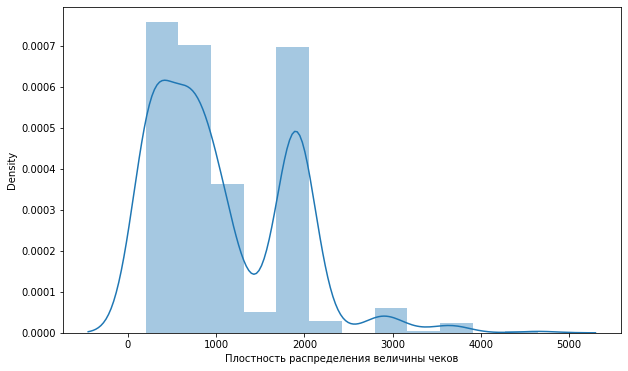

In [242]:
plt.figure(figsize=(10,6))
sns.distplot(df_checks.rev)
plt.xlabel('Величина чека')
plt.xlabel('Плостность распределения величины чеков')

По плотности распределения величины чеков видно, что чаще всего пользователи покупали на сумму от 200 у.е. до 700 у.е., а также 1900 у.е. 

In [243]:
df_checks.rev.value_counts().head(10)

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
Name: rev, dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Величина чека')

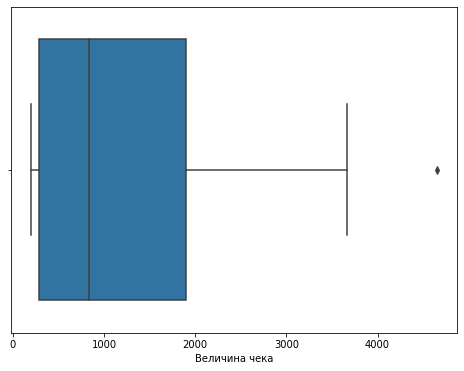

In [244]:
plt.figure(figsize=(8,6))
sns.boxplot(df_checks.rev)
plt.xlabel('Величина чека')

In [245]:
df_checks[df_checks.rev>4000]

,student_id,rev
231,1711305,4650.0


Наблюдение с максимальной величиной чека в 4650 у.е. является выбросом

Проверим нет ли других аномалий в данных по чекам. Все пользователи, проводившие транзакции должны быть в датасете active_studs

In [246]:
541-df_checks.student_id.isin(df_active_studs['student_id']).sum()

149

149 пользователей, совершивших покупки в дни проведения эксперимента, не отражены в датасете с активными действиями во время эксперимента: либо это техническая ошибка и данные пользователи должны быть включены в датасет с активными действиями, либо существует способ оплаты, при котором нет необходимости заходить на саму платформу: например, отсроченный платёж и т.п. Во 2 случае нецелесообразно рассматривать данных пользователей как учавствующих в эксперименте, если они не имели никакого влияния от внедрения новой системы оплаты

Допустим, технической ошибки не было. Тогда не будем рассматривать данных пользователей и уменьшим датасет с чеками на их количество.

In [247]:
df_checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [248]:
df_checks_only_active=df_checks.query('student_id.isin(@df_active_studs.student_id)')
df_checks_only_active

,student_id,rev
0,1627,990.0000
4,100300,990.0000
8,108270,290.0000
26,264473,1900.0001
27,274352,690.0000
...,...,...
536,5645737,1900.0000
537,5651566,1900.0000
538,5662322,1900.0000
539,5681918,1900.0000


Соединим новый датасет с пользователями, которые совершили покупку с оплатой в течение дней, когда велось наблюдение, с датасетом, содержащим информацию о их принадлежности к контрольной группе A или целевой группе B

In [249]:
df_groups_all.rename(columns={'id':'student_id'}, inplace=True)
df_groups_all

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [250]:
ids_and_checks=df_checks_only_active.merge(df_groups_all, how='inner', on='student_id', right_index=True)
ids_and_checks

,student_id,rev,grp
0,1627,990.0000,A
4,100300,990.0000,B
8,108270,290.0000,B
26,264473,1900.0001,B
27,274352,690.0000,B
...,...,...,...
536,5645737,1900.0000,B
537,5651566,1900.0000,B
538,5662322,1900.0000,B
539,5681918,1900.0000,B


## Определение необходимых метрик

### 1) Количество покупок в контрольной группе A и целевой группе B

In [251]:
ids_and_checks.groupby('grp').agg({'student_id':'count'}).rename(columns={'student_id':'Количество уникальных пользователей в группе'})

,Количество уникальных пользователей в группе
grp,
A,78
B,314


### 2) Средний чек пользователей в контрольной группе A и целевой группе B - ARPPU

In [252]:
round(ids_and_checks.groupby('grp').agg({'rev':'mean'}).rename(columns={'rev':'Средний чек пользователей, у.е.'}),2)

,"Средний чек пользователей, у.е."
grp,
A,933.59
B,1257.88


На первый вгляд, наблюдаются различия в среднем чеке у пользователей. Далее выясним, насколько достоверными они являются с помощью статистических тестов. 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Плостность распределения величины чеков')

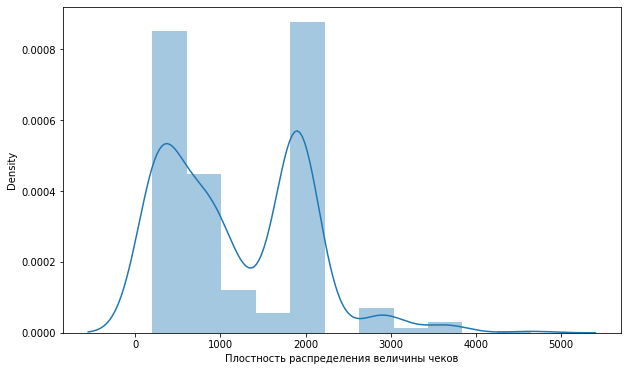

In [253]:
plt.figure(figsize=(10,6))
sns.distplot(ids_and_checks.rev)
plt.xlabel('Величина чека')
plt.xlabel('Плостность распределения величины чеков')

Как и ранее, наблюдаем распределение величины чека пользователей отличное от нормального
Можем использовать t-тест, но только при условии гомогенности условий и большого размера выборки (условие выполнено)

Т.к. данные ненормально распределены, то для проверки дисперсии на гомогенность вместо теста Бартлетта (чувствителен к выбросам) критерий Левена

In [254]:
#H0: Дисперсии однородны
from scipy.stats import levene
statistic, p_value = levene(ids_and_checks.query('grp=="A"').rev, ids_and_checks.query('grp=="B"').rev)
print("p-value:",round(p_value,4))
if p_value > 0.05:
    print("Дисперсии однородны (не отвергаем нулевую гипотезу)")
else:
    print("Дисперсии неоднородны (отвергаем нулевую гипотезу)")

p-value: 0.0803
Дисперсии однородны (не отвергаем нулевую гипотезу)


In [255]:
#H0: Средняя величина чека в контрольной и целевой группе равна
from scipy.stats import ttest_ind
statistic, p_value = ttest_ind(ids_and_checks.query('grp=="A"').rev, ids_and_checks.query('grp=="B"').rev)
print("p-value:", round(p_value,4))

if p_value > 0.05:
    print("Нет статистически значимых различий (не отвергаем нулевую гипотезу)")
else:
    print("Есть статистически значимые различия (отвергаем нулевую гипотезу)")

p-value: 0.0019
Есть статистически значимые различия (отвергаем нулевую гипотезу)


### Таким образом, различия в величине среднего чека в целевой и контрольной группе являются значимыми при уровне значимости 5% => Средний чек у пользователей в целевой группе, на которых тестировался новый функционал оплаты, выше среднего чека у пользователей контрольной группы на 324 у.е.

### 3) Средний чек активных пользователей в целевой и контрольной группе - ARPAU

In [256]:
active_users_with_labels_and_check=df_active_studs.merge(df_checks, on  = 'student_id', how = 'left').merge(df_groups_all, on = 'student_id', how = 'inner')
active_users_with_labels_and_check.groupby('grp').agg({'student_id':'count'}).rename(columns={'student_id':'Количество уникальных активных пользователей в группе'})

,Количество уникальных активных пользователей в группе
grp,
A,1538
B,6803


### Ввиду того, что увеличился чек платящих пользователей в целевой группе, увеличился и чек активных пользователей в целевой группе, но в меньшей степени (на 11 у.е.) за счёт многочисленности активных, но непокупающих пользователей в целевой группе

In [257]:
active_users_with_labels_and_check=df_active_studs.merge(df_checks, on  = 'student_id', how = 'left').merge(df_groups_all, on = 'student_id', how = 'inner')
round((active_users_with_labels_and_check.groupby('grp').agg({'rev':'sum'})\
         .rename(columns={'rev':'student_id'})/active_users_with_labels_and_check.groupby('grp')\
         .agg({'student_id':'count'})).rename(columns={'student_id':'Средний чек активных пользователей, у.е.'}),3)

,"Средний чек активных пользователей, у.е."
grp,
A,47.347
B,58.059


### 4) Конверсия в покупку (активного пользователя)

Создадим признак is_purchase, чтобы было удобней понять, кто из активных пользователей совершил покупку, а кто нет

In [258]:
active_users_with_labels_and_check['is_purchase'] = active_users_with_labels_and_check.rev.apply(lambda x: 0 if pd.isna(x) else 1)
active_users_with_labels_and_check

,student_id,rev,grp,is_purchase
0,581585,NaN,A,0
1,5723133,NaN,A,0
2,3276743,NaN,B,0
3,4238589,NaN,A,0
4,4475369,NaN,B,0
...,...,...,...,...
8336,1794344,NaN,B,0
8337,296883,NaN,B,0
8338,3598448,NaN,B,0
8339,3610547,290.0,B,1


In [259]:
conversion=active_users_with_labels_and_check.pivot_table(index = 'is_purchase', columns = 'grp', values = 'student_id', aggfunc = 'count')
conversion

grp,A,B
is_purchase,,
0,1460,6489
1,78,314


In [260]:
conversion.loc['sum']=conversion.iloc[0]+conversion.iloc[1]

In [261]:
convertion_in_A=round((conversion.iloc[1,0]/conversion.iloc[2,0])*100,3)
convertion_in_B=round((conversion.iloc[1,1]/conversion.iloc[2,1])*100,3)

In [262]:
print(f'Конверсия контрольной группы: { convertion_in_A}')
print(f'Конверсия целевой группы: { convertion_in_B}')

Конверсия контрольной группы: 5.072
Конверсия целевой группы: 4.616


Конверсия в покупку в целевой группе несколько ниже, чем в контрольной

In [263]:
conversion.iloc[:2]

grp,A,B
is_purchase,,
0,1460,6489
1,78,314


Для проверки того является ли разница в конверсиях у контрольной и целевой групп значимой используем тест хи-квадрат

H0: категориальные переменные независимы - в нашем случае факт покупки и принадлежность к определенной группе во время эксперимента

In [264]:
import scipy.stats as stats
chi2, p, dof, expected = stats.chi2_contingency(conversion.iloc[:2])

print(f'P-value: {round(p,3)}')

if p > 0.05:
    print("Факт покупки и принадлежность к определенной группе во время эксперимента являются независимыми признаками (не отвергаем нулевую гипотезу)")
else:
    print("Факт покупки и принадлежность к определенной группе во время эксперимента не являются независимыми признаками (отвергаем нулевую гипотезу)")

P-value: 0.486
Факт покупки и принадлежность к определенной группе во время эксперимента являются независимыми признаками (не отвергаем нулевую гипотезу)


### Статистически значимые различия в уровне конверсии в покупку в рассматриваемых группах не выявлены => новый механизм оплаты не имел влияния на эту метрику

# Итог по 1 заданию: 
- В рамках анализа данной ситуации необходимо обратить внимание на такие метрики как : ARPPU, ARPAU, Конверсия в покупку
- В ходе исследования введенных изменений, касающихся системы оплаты было выяснено, что средний чек на платящего пользователя в целевой группе на 324 у.е. выше, чем в контрольной. Данные различия оказались статистически значимыми. Выручка на активного пользователя в целевой группе также выше, но лишь на 11 долл. Изменений в уровне конверсии активных пользователей в покупку в разрезе рассматриваемых групп после внедрения нового функционала выявлено не было: конверсия осталось равна приблизительно 5%.
- В результате анализа данных метрик, можно сделать вывод о необходимости внедрения новой системы оплаты

# Задание 2 

## 2.1

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин. Необходимо написать **оптимальный** запрос, который даст информацию о количестве очень усердных студентов.

In [265]:
import pandahouse as ph

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     } 
# Импортируем библиотеку pandahouse и подключаемся к  нужной базе данных в Clickhouse

Атрибуты таблицы:
- st_id (int) - ID ученика
- timest (timestamp) - Время решения карточки
- correct (bool) - Правильно ли решена горошина?
- subject (text) - Дисциплина, в которой находится горошина

In [266]:
query_1 = """SELECT DISTINCT(toStartOfMonth(timest))
from default.peas
"""

In [267]:
ph.read_clickhouse(query_1, connection = connection_default)

,toStartOfMonth(timest)
0,2021-10-01


В данной таблицы записи указаны за 1 месяц - октябрь 2021

In [268]:
#используем табличные выражения, чтобы сделать запрос более читаемым
query_2 = """
WITH very_hardworking_students AS 
    (SELECT st_id,
    SUM(correct) AS correct_peas
    FROM default.peas
    GROUP BY st_id
    HAVING correct_peas >= 20)

    SELECT uniqExact(st_id) AS number_of_students
    FROM very_hardworking_students
"""

In [269]:
ph.read_clickhouse(query_2, connection = connection_default)

,number_of_students
0,136


### Количество очень усердных учеников равно 136

Если в текущую таюлицу будут добавляться записи за разные месяцы, то необходимо будет использовать следующий запрос

In [270]:
query_3 = """
WITH very_hardworking_students AS 
    (SELECT st_id, 
    toStartOfMonth(timest) AS month,
    SUM(correct) AS correct_peas
    FROM default.peas
    GROUP BY st_id,month
    HAVING correct_peas >= 20)

    SELECT month, uniqExact(st_id) AS number_of_students
    FROM very_hardworking_students
    GROUP BY month
"""

In [271]:
ph.read_clickhouse(query_3, connection = connection_default)

,month,number_of_students
0,2021-10-01,136


## 2.2

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Даны таблицы: default.peas, default.studs и default.final_project_check

default.studs:
- st_id (int) - ID ученика
- test_grp (text) - Метка ученика в данном эксперименте (pilot, control)

default.final_project_check:
- st_id (int) - ID ученика
- sale_time (timestamp) - время покупки
- money (int) - цена, по которой приобрели курс
- subject (text) - предмет (всего их 5)

Необходимо в **одном запросе** выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.
**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
**Активным** по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [272]:
query_4 = """
       WITH revenue_and_group_info AS 
    (SELECT st_id, 
           revenue_per_user,
           test_grp
    FROM default.studs AS stud
    LEFT JOIN
    (SELECT
    st_id, SUM(money) AS revenue_per_user
    FROM default.final_project_check
    GROUP BY st_id) revenue ON stud.st_id = revenue.st_id),
    
ARPU_and_cr_by_all_students AS
    (SELECT test_grp,
    ROUND(SUM(revenue_per_user) / uniqExact(st_id),3) AS ARPU,
    ROUND((uniqExactIf(st_id, revenue_per_user != 0)*100 / uniqExact(st_id)),3) AS convertion_rate
    FROM revenue_and_group_info
    GROUP BY test_grp), 
    
ARPAU_and_cr_by_active_users AS
    (SELECT test_grp,
            ROUND(SUM(revenue_per_user) / uniqExactIf(st_id, active_or_not = 'active'),3) AS ARPAU,
            ROUND((uniqExactIf(st_id, active_or_not = 'active' AND revenue_per_user != 0) / uniqExactIf(st_id, active_or_not = 'active'))*100,3) AS cr_by_active_users
    FROM revenue_and_group_info r
    LEFT JOIN
    (SELECT st_id,
            SUM(correct) AS number_of_tasks,
            'active' AS active_or_not
    FROM default.peas
    GROUP BY st_id
    HAVING number_of_tasks > 10) t1 ON r.st_id = t1.st_id
    GROUP BY test_grp),
    
 cr_by_math AS 
    (SELECT test_grp,
            ROUND((uniqExactIf(st_id, active_or_not_in_math = 'math_active' AND revenue_per_user != 0) / uniqExactIf(st_id, active_or_not_in_math = 'math_active'))*100,3) AS cr_math
    FROM revenue_and_group_info r
    LEFT JOIN
        (SELECT st_id,
                SUM(correct) AS number_of_tasks,
                'math_active' AS active_or_not_in_math
        FROM default.peas
        WHERE subject = 'Math'
        GROUP BY st_id
        HAVING number_of_tasks >= 2) m 
    ON r.st_id = m.st_id
    GROUP BY test_grp)
        
SELECT  ARPU_and_cr_by_all_students.test_grp AS group,
        ARPU,
        ARPAU,
        convertion_rate,
        cr_by_active_users,
        cr_math
FROM ARPU_and_cr_by_all_students
JOIN ARPAU_and_cr_by_active_users ON ARPU_and_cr_by_all_students.test_grp = ARPAU_and_cr_by_active_users.test_grp
JOIN cr_by_math ON ARPU_and_cr_by_all_students.test_grp = cr_by_math.test_grp
        """

In [273]:
ph.read_clickhouse(query_4, connection = connection_default)

,group,ARPU,ARPAU,convertion_rate,cr_by_active_users,cr_math
0,control,4540.984,10905.512,4.918,11.024,10.204
1,pilot,11508.475,35364.583,10.847,26.042,14.286


# Задание 3 

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [274]:
def insert_new_data(public_key): 
#sep не указываем в качестве аргумента, потому что в датафрейме разделитель - запятая, а она и так стоит по дефолту в read_csv
    
    # загружаем данные через API
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    url = base_url + urlencode(dict(public_key = public_key))
    
    query=requests.get(url)
    json_data = json.loads(query.text)
    
    df=pd.read_csv(json_data['href'])
    
    # Изменим заголовки на изначальные, т.к. они могут отличаться
    df = df.rename(columns = {df.columns[0]: 'id', df.columns[1]: 'grp'})
    
    # Соеденим датафреймы
    all_groups_df = pd.concat([df_groups, df])
    
    
    
    # Расчёт метрик
    
    active_users_and_check = df_active_studs.merge(df_checks, on = 'student_id', how = 'left')
    active_users_and_check.rename(columns={'student_id':'id'}, inplace=True)
    active_users_check_group = pd.merge(active_users_and_check, all_groups_df, on = 'id', how = 'left')
    
    ARPPU = active_users_check_group.groupby('grp').agg({'rev': 'mean'}).rename(columns = {'rev': 'ARPPU'}).round(3)
    
    ARPAU = active_users_check_group.groupby('grp').agg({'rev': 'sum', 'id': 'nunique'})
    ARPAU['ARPAU']=round(ARPAU['rev']/ARPAU['id'],3)
    
    # Convertion rate from active users
    active_users_check_group['purchase_or_not'] = active_users_check_group.rev.apply(lambda x: 0 if pd.isna(x) else 1)
    cr_from_active = active_users_check_group.pivot_table(index = 'purchase_or_not', columns = 'grp', values = 'id', aggfunc = 'count')
    cr_from_active.loc['sum']=cr_from_active.iloc[0]+cr_from_active.iloc[1]
    cr_from_active=cr_from_active.transpose()
    cr_from_active['conv']=round(cr_from_active.iloc[:,1]*100/cr_from_active.iloc[:,2],3)
    
    return  ARPPU.merge(ARPAU['ARPAU'], on = 'grp').merge(cr_from_active['conv'], on = 'grp') 

In [275]:
metrics=insert_new_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
metrics

,ARPPU,ARPAU,conv
grp,,,
A,933.590,47.347,5.072
B,1257.879,58.059,4.616


In [276]:
def visualization(metrics):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.barplot(data = metrics, x = 'grp', y = 'ARPPU', ax = axs[0])
    axs[0].set_title('ARPPU')
    
    sns.barplot(data = metrics, x = 'grp', y = 'ARPAU', ax = axs[1])
    axs[1].set_title('ARPAU')
    
    sns.barplot(data = metrics, x = 'grp', y = 'conv', ax = axs[2])
    axs[2].set_title('Conversion rate from active users, %')

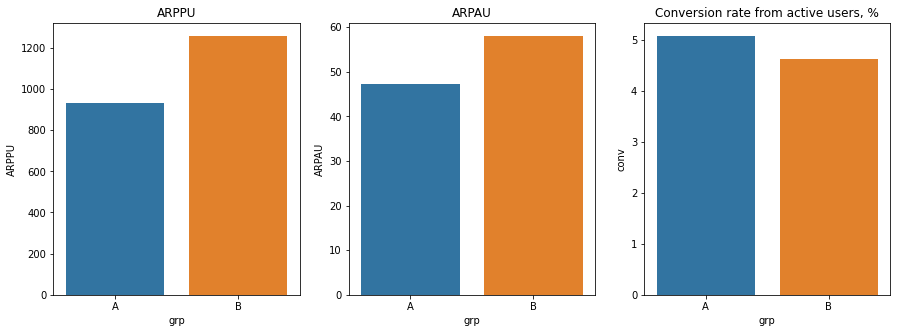

In [277]:
visualization(metrics.reset_index())